In [1]:
import torch
from torch import nn
from torch.optim import Adam 
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is:", device)

Device is: cuda


## Load Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
])

In [4]:
train_dataset = datasets.MNIST(root="./data", download=True, train=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", download=True, train=False, transform=transform)

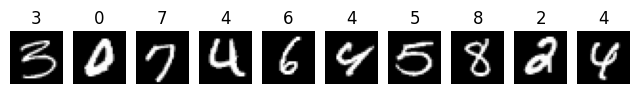

In [5]:
# Displaying random samples
fig, axis = plt.subplots(1, 10, figsize=(8, 1))

for ax in axis:
    ind = np.random.randint(len(train_dataset))
    ax.imshow(train_dataset.data[ind], cmap="gray")
    ax.set_title(train_dataset.targets[ind].item())
    ax.axis(False)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

## Model Architecture

In [39]:
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, num_classes=10):
        super(CVAE, self).__init__()
        
        self.num_classes=num_classes
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1+num_classes, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (input_dim//8) * (input_dim//8), hidden_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 64 * (input_dim//8) * (input_dim//8)),
            nn.ReLU(),
            nn.Unflatten(1, (64, input_dim//8, input_dim//8)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(mu.device)
        return mu + std*eps

    def forward(self, x, labels):
        labels_one_hot = nn.functional.one_hot(labels, num_classes=self.num_classes).float().view(-1, self.num_classes)
        
        # Expand label to match image dimensions and concatenate
        labels_expanded = labels_one_hot.unsqueeze(-1).unsqueeze(-1) # shape (batch, num_classes, 1, 1)
        labels_expanded = labels_expanded.expand(-1, -1, x.shape[2], x.shape[3]) # (batch, num_classes, H, W)
        
        x = torch.cat([x, labels_expanded], dim=1)
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        
        z = torch.cat([z, labels_one_hot], dim=1) 
        recon_x = self.decoder(z)
        return recon_x, mu, logvar    

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
model = CVAE(32, 15, 128)
t = torch.randn(7, 1, 32, 32)
l = torch.randint(0, 10, (7,))
print(t.shape)
x, y, z = model(t, l)

print(f'The model has {count_parameters(model):,} trainable parameters')
x.shape, y.shape, z.shape

torch.Size([7, 1, 32, 32])
torch.Size([7, 1, 32, 32]) torch.Size([7, 10, 32, 32])
The model has 209,663 trainable parameters


(torch.Size([7, 1, 32, 32]), torch.Size([7, 15]), torch.Size([7, 15]))

## Training

In [35]:
def loss_function(recon_x, x, mu, logvar):
    loss_recon = nn.functional.mse_loss(recon_x, x, reduction="sum")
    loss_KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss_vae = loss_recon + loss_KL
    return loss_vae

In [44]:
def train_per_epoch():
    model.train()
    
    train_losses = []
    for batch, labels in train_loader:
        
        x , labels = batch.to(device), labels.to(device)
        optim.zero_grad()
        
        recon_x, mu, logvar = model(x, labels)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optim.step()
        
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
        
    return train_loss

def validate():
    model.eval()
    
    val_losses = []
    with torch.no_grad():
        for batch, labels in test_loader:
            x, labels = batch.to(device), labels.to(device)
            
            recon_x, mu, logvar = model(x, labels)
            loss = loss_function(recon_x, x, mu, logvar)
            val_losses.append(loss.item())
    
    val_loss = np.mean(val_losses)
    return val_loss

def train(first_epoch, num_epochs):
    train_losses, val_losses = [], []
    
    for epoch in range(first_epoch, first_epoch + num_epochs):
        
        train_loss = train_per_epoch()
        val_loss = validate()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'[{epoch:03d}] train loss: {train_loss:04f}  '
              f'val loss: {val_loss:04f}')
        
        
        # visualize random sample result
        idx = np.random.randint(0, 64)
        mean = 0.1307
        std = 0.3081

        sample_batch, labels = next(iter(test_loader))
        recon_batch, _, _ = model(sample_batch.cuda(), labels.cuda())
        recon_batch = recon_batch.cpu().detach().numpy()

#         gt = (sample_batch.numpy()[idx, 0] * 255).astype(np.uint8)
#         rc = (recon_batch[idx, 0] * 255).astype(np.uint8)
        
        gt = sample_batch.cpu().numpy()[idx, 0] * std + mean
        rc = recon_batch[idx, 0] * std + mean
        gt = (gt * 255).astype(np.uint8)
        rc = (rc * 255).astype(np.uint8)


        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Ground Truth')
        plt.imshow(gt, cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title('Reconstructed')
        plt.imshow(rc, cmap="gray")
        plt.savefig(f"results/conditional_res{epoch+1}.png")
        plt.close('all')

    return train_losses, val_losses 

In [45]:
model = CVAE(input_dim=32, hidden_dim=128, latent_dim=15).to(device)
optim = Adam(model.parameters(), lr=1e-3)
first_epoch = 0
num_epochs = 20
train_losses, val_losses = train(first_epoch, num_epochs)

[000] train loss: 35551.862666  val loss: 30537.986241
[001] train loss: 29928.372257  val loss: 29901.683233
[002] train loss: 29513.775983  val loss: 29652.204350
[003] train loss: 29302.886425  val loss: 29485.662122
[004] train loss: 29167.751217  val loss: 29386.934303
[005] train loss: 29070.111141  val loss: 29319.797198
[006] train loss: 29000.012986  val loss: 29251.017740
[007] train loss: 28938.233879  val loss: 29194.785405
[008] train loss: 28881.242096  val loss: 29154.016608
[009] train loss: 28841.406104  val loss: 29125.170021
[010] train loss: 28805.455149  val loss: 29083.730046
[011] train loss: 28771.972573  val loss: 29063.600175
[012] train loss: 28746.915357  val loss: 29049.179457
[013] train loss: 28712.638778  val loss: 29016.319616
[014] train loss: 28695.941210  val loss: 28990.389543
[015] train loss: 28675.301821  val loss: 28969.681666
[016] train loss: 28656.457048  val loss: 28964.072402
[017] train loss: 28642.408149  val loss: 28937.120179
[018] trai

## Generate new samples

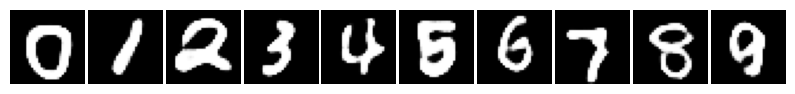

In [47]:
import matplotlib.gridspec as gridspec
import os

z = torch.randn(10, 15)
c = torch.eye(10, 10) # [one hot labels for 0-9]
z = torch.cat((z, c), dim=-1).to(device)
model.eval()
samples = model.decoder(z).data.cpu().numpy()

save_file = f'results/conditional_vae_generation.jpg'

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(32,32), cmap='Greys_r')
    plt.savefig(save_file)